In [1]:
# Basic
from datetime import datetime, timedelta
import time

# Data Analysis Specific
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy

# Marchine Learning Specific
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# IPython magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

# How to define the geo data?
1. Instead of define the building, I would like to directly map the city of Detroit as grid.
2. Here, I map the city with width of 200 and height of 400. Thus, the city is 80000 "pixels", or buildings. Of course, more pixels to sample from the original data will get more accurate result. 
3. Surely, not all the pixels are valid; only some of them is indeed in the city of Detroit. We will find there are **24172** valid pixels (take violation data as example).
4. The range of the data has taken the outliers into consideration.

In [66]:
DATA_PATH = './data/'
DETROIT_LAT = (42.252, 42.452)
DETROIT_LNG = (-83.295, -82.895)
SIZE_RATIO = 1000
DETROIT_WIDTH = (DETROIT_LAT[1] - DETROIT_LAT[0])*SIZE_RATIO
DETROIT_HEIGHT =  (DETROIT_LNG[1] - DETROIT_LNG[0])*SIZE_RATIO
print DETROIT_WIDTH, DETROIT_HEIGHT, DETROIT_WIDTH/DETROIT_HEIGHT

200.0 400.0 0.5


In [3]:
raw_violation = pd.read_csv(DATA_PATH + 'detroit-blight-violations.csv', low_memory=False)
raw_311 = pd.read_csv(DATA_PATH + 'detroit-311.csv', low_memory=False)
raw_crime = pd.read_csv(DATA_PATH + 'detroit-crime.csv', low_memory=False)
raw_permit = pd.read_csv(DATA_PATH + 'detroit-demolition-permits.tsv.csv', low_memory=False)

In [36]:
def violation_lat_lng():
    lat_lng = raw_violation['ViolationAddress'].map(lambda x: x.split('\n')[-1][1:-1])
    lat = lat_lng.map(lambda x: float(x.split(',')[0]))
    lng = lat_lng.map(lambda x: float(x.split(',')[1]))
    addr = pd.DataFrame()
    addr['lat'] = lat
    addr['lng'] = lng
    # There'are maybe some outliers, especially the default location of Detroit City
    pass
    return addr

In [37]:
tmp = violation_lat_lng().apply(lambda x: (x['lat'],x['lng']),axis = 1)
print len(tmp)
print len(tmp.unique())

307804
96314


In [69]:
def generateDataMap(data):
    data_map = np.zeros(shape=(int(DETROIT_WIDTH),int(DETROIT_HEIGHT)))
    for row in range(len(data)):
        lat, lng = data.ix[row,:]
        if DETROIT_LAT[0]<= lat < DETROIT_LAT[1] or DETROIT_LNG[0]<= lng < DETROIT_LNG[1]:
            r = int((lat - DETROIT_LAT[0])*SIZE_RATIO) 
            c = int((lng - DETROIT_LNG[0])*SIZE_RATIO)
            data_map[r,c] +=1
    return data_map            

In [72]:
violation_geo = violation_lat_lng()

In [140]:
violation_map = generateDataMap(violation_geo)

In [141]:
violation_map.flatten('C') # row major，then column

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [142]:
def generateDataMapFrame(data_map):
    lat = range(data_map.shape[0])
    lng = range(data_map.shape[1])
    data_map_frame = pd.DataFrame()
    data_map_frame['lat'] = reduce(lambda x,y: x+y,map(lambda x: [x]*data_map.shape[1], lat))
    data_map_frame['lng'] = lng*data_map.shape[0]
    data_map_frame['count'] = data_map.flatten('C')
    return data_map_frame

In [168]:
def labeledDataMapFrame(data_map):
    data_map_frame = pd.DataFrame(data_map.T, 
                                  columns = np.linspace(DETROIT_LAT[0],DETROIT_LAT[1],DETROIT_WIDTH),
                                  index = np.linspace(DETROIT_LNG[0],DETROIT_LNG[1],DETROIT_HEIGHT))
    data_map_frame.columns.name = 'lat'
    data_map_frame.index.name = 'lng'
    return data_map_frame.T

In [170]:
labeledDataMapFrame(violation_map)

lng,-83.295,-83.2939974937,-83.2929949875,-83.2919924812,-83.2909899749,-83.2899874687,-83.2889849624,-83.2879824561,-83.2869799499,-83.2859774436,...,-82.9040225564,-82.9030200501,-82.9020175439,-82.9010150376,-82.9000125313,-82.8990100251,-82.8980075188,-82.8970050125,-82.8960025063,-82.895
lat,,,,,,,,,,,,,,,,,,,,,
42.252000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42.253010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42.254020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42.255030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42.256040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42.257051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42.258061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42.259071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42.260081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
violation_frame = generateDataMapFrame(violation_map)


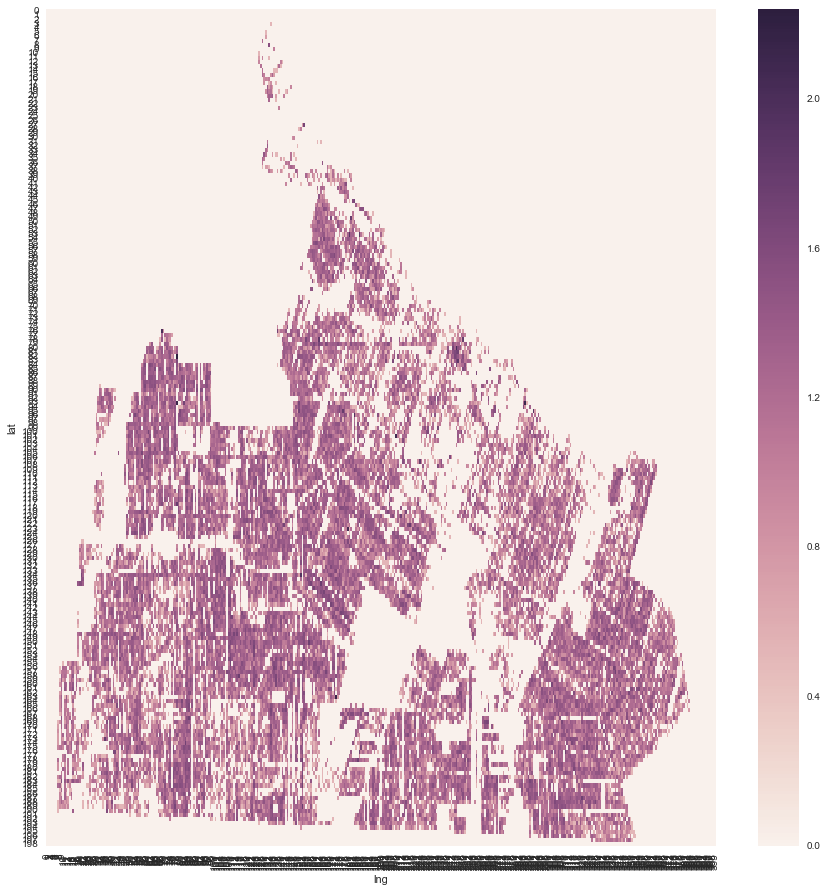

In [177]:
sns.set()
# sns.palplot(sns.light_palette("red"))
fig, ax = plt.subplots(figsize = (15,15))
violation_frame = violation_frame[violation_frame['count'] < 20000]
violation_frame['count'] = np.log(violation_frame['count']+1)
sns.heatmap(violation_frame.pivot("lat", "lng", "count"))

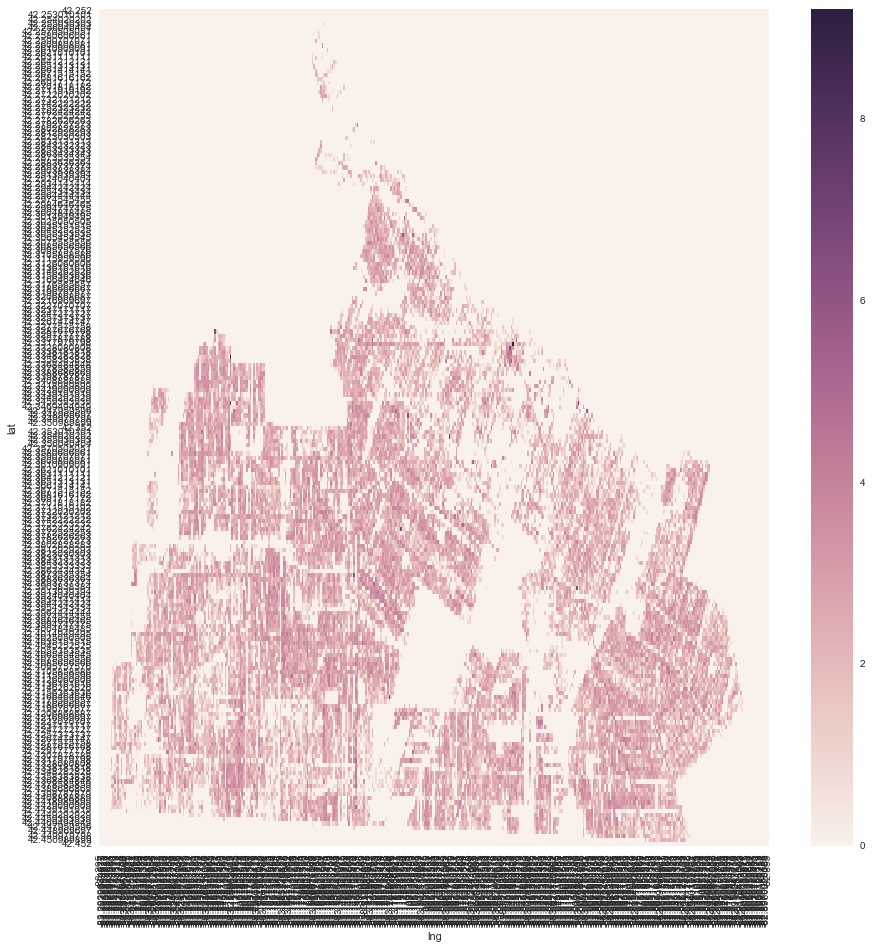

In [181]:
sns.set()
fig, ax = plt.subplots(figsize = (15,15))
violation_frame = labeledDataMapFrame(violation_map)
violation_frame[violation_frame > 10000] = 10000
violation_frame = np.log(violation_frame+1)
sns.heatmap(violation_frame)

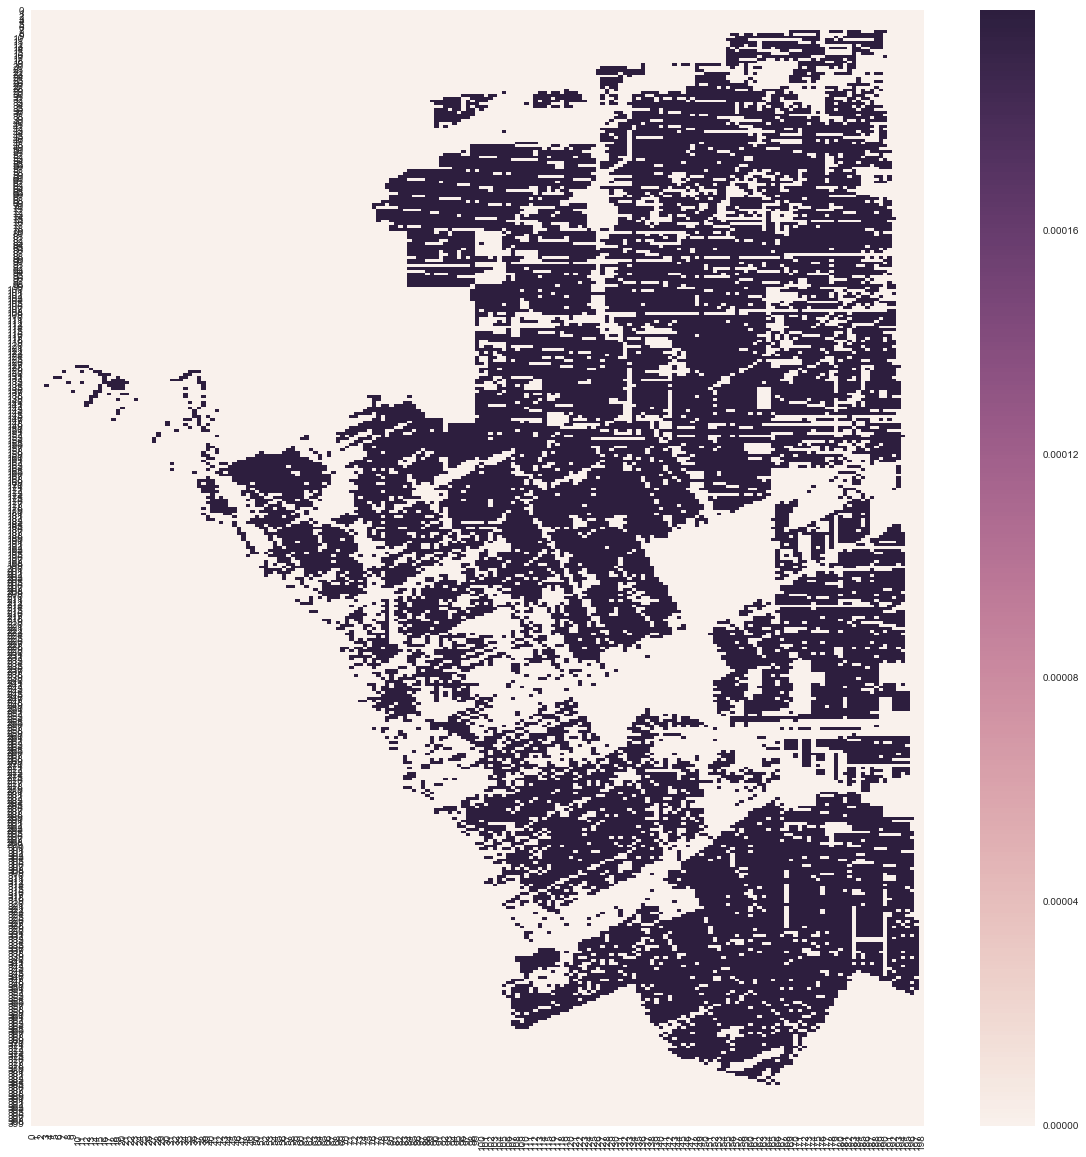

In [190]:
sns.set()
fig, ax = plt.subplots(figsize = (20,20))
# violation_frame[violation_frame > 10000] = 10000
for _ in range(10000):
    violation_map = np.log(violation_map+1)
sns.heatmap(violation_map.T)

In [152]:
violation_frame.pivot("lat", "lng", "count")

lng,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
lat,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
np.log(violation_frame['count'])

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
         ..
79570   NaN
79571   NaN
79572   NaN
79573   NaN
79574   NaN
79575   NaN
79576   NaN
79577   NaN
79578   NaN
79579   NaN
79580   NaN
79581   NaN
79582   NaN
79583   NaN
79584   NaN
79585   NaN
79586   NaN
79587   NaN
79588   NaN
79589   NaN
79590   NaN
79591   NaN
79592   NaN
79593   NaN
79594   NaN
79595   NaN
79596   NaN
79597   NaN
79598   NaN
79599   NaN
Name: count, dtype: float64

In [98]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


In [114]:
violation_frame = violation_frame[violation_frame['count'] < 20000].dropna()
violation_frame.max()

lat       198.0
lng       399.0
count    4479.0
dtype: float64

In [ ]:
voildation_frame['count'][voildation_frame['count'] < 10000] = 